Learn transfer learning by fine tuning VGG16 for tuberculosis classification
Based on https://github.com/zeeshannisar/Transfer-Learning-and-Fine-Tuning-with-Pre-Trained-Networks/blob/master/Transfer%20Learning%20with%20VGG16/Fine%20tuning%20with%20Pretrained%20VGG16%20for%20Tuberculosis%20Classification.ipynb

In [2]:
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
%matplotlib inline
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# os.chdir('content/drive/My Drive/GitHub Repositories/Transfer Learning and Fine Tuning with Pre-Trained Networks')
trainDir = '../xrays-x64/train'
validDir = '../xrays-x64/test'
testDir = ''

IMG_SIZE = 64
datagen = ImageDataGenerator(rescale=1./255, 
                             samplewise_center=False, 
                             samplewise_std_normalization=False, 
                             horizontal_flip = True, 
                             vertical_flip = False, 
                             height_shift_range = 0.15, 
                             width_shift_range = 0.15, 
                             rotation_range = 5, 
                             shear_range = 0.01,
                             fill_mode = 'nearest',
                             zoom_range=0.1,  
                             )

train_gen = datagen.flow_from_directory(
    directory=trainDir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=2019)

valid_gen = datagen.flow_from_directory(
    directory=validDir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    seed=2019)

Found 721 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


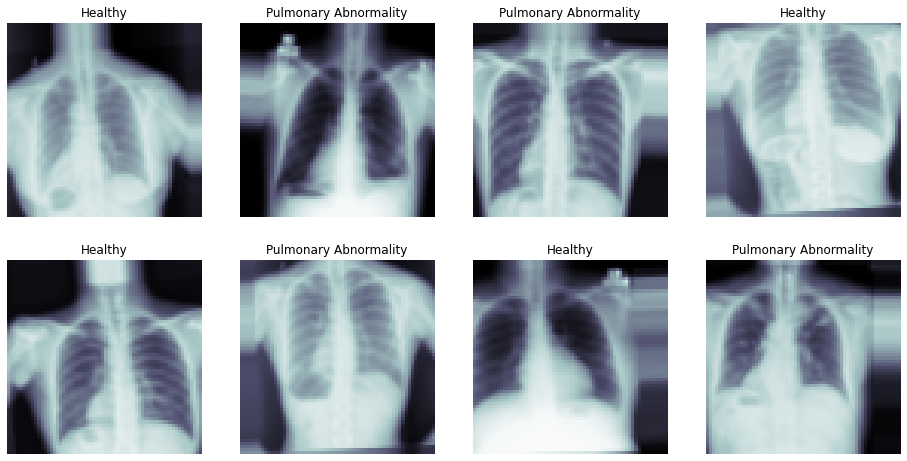

In [3]:
import matplotlib.pyplot as plt

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = 0, vmax = 1)
    c_ax.set_title('%s' % ('Pulmonary Abnormality' if np.argmax(c_y)>0.5 else 'Healthy'))
    c_ax.axis('off')

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import *

img_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs = Input(img_shape)
num_classes = 2

vgg16_model = VGG16(input_shape =  img_shape, include_top = False, weights = 'imagenet')
vgg16_model.trainable = False
outputs = vgg16_model(inputs)
outputs = BatchNormalization(name = 'BatchNormalization')(outputs)
outputs = GlobalAveragePooling2D()(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(256)(outputs)
outputs = LeakyReLU(alpha=0.1)(outputs)
outputs = Dropout(0.25)(outputs)
outputs = Dense(num_classes, activation = 'softmax')(outputs)

model = Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
BatchNormalization (BatchNor (None, 2, 2, 512)         2048      
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0     

In [6]:
from keras.models import load_model

In [7]:
model = load_model('vgg16-x64-checkpoint-100')

In [8]:
from tensorflow.keras.callbacks import *

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="'val_acc'", mode="auto", patience=30) 

callbacks_list = [early, reduceLROnPlat]

STEP_SIZE_TRAIN=train_gen.n // train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n // valid_gen.batch_size

model.fit_generator(train_gen, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_gen, validation_steps=STEP_SIZE_VALID,
                    epochs = 100, callbacks = callbacks_list)
model.save('vgg16-x64-checkpoint-200')

/home/linuxfan/cvut/bpr/venv/lib/python3.9/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpgpgl0b2_.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpgpgl0b2_.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
45/45 [==============================] - 14s 51ms/step - loss: 0.4737 - accuracy: 0.7872 - val_loss: 0.5890 - val_accuracy: 0.7188
Epoch 2/100
45/45 [==============================] - 2s 34ms/step - loss: 0.4410 - accuracy: 0.7958 - val_loss: 0.5394 - val_accuracy: 0.7031
Epoch 3/100
45/45 [==============================] - 2s 34ms/step - loss: 0.4281 - accuracy: 0.8099 - val_loss:

Epoch 26/100
45/45 [==============================] - 1s 33ms/step - loss: 0.4397 - accuracy: 0.8128 - val_loss: 0.5993 - val_accuracy: 0.6875
Epoch 27/100
45/45 [==============================] - 2s 34ms/step - loss: 0.4388 - accuracy: 0.7972 - val_loss: 0.5314 - val_accuracy: 0.7500
Epoch 28/100
45/45 [==============================] - 2s 34ms/step - loss: 0.4195 - accuracy: 0.8057 - val_loss: 0.5615 - val_accuracy: 0.7500
Epoch 29/100
45/45 [==============================] - 1s 33ms/step - loss: 0.4509 - accuracy: 0.7801 - val_loss: 0.6316 - val_accuracy: 0.7031

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.
Epoch 30/100
45/45 [==============================] - 1s 33ms/step - loss: 0.4679 - accuracy: 0.7745 - val_loss: 0.5018 - val_accuracy: 0.7656
Epoch 31/100
45/45 [==============================] - 2s 34ms/step - loss: 0.4694 - accuracy: 0.7745 - val_loss: 0.4997 - val_accuracy: 0.8125
Epoch 32/100
45/45 [==============================] - 1s 33m

45/45 [==============================] - 1s 31ms/step - loss: 0.4446 - accuracy: 0.7929 - val_loss: 0.5320 - val_accuracy: 0.7812
Epoch 54/100
45/45 [==============================] - 1s 32ms/step - loss: 0.4377 - accuracy: 0.7972 - val_loss: 0.5098 - val_accuracy: 0.7500
Epoch 55/100
45/45 [==============================] - 1s 32ms/step - loss: 0.4260 - accuracy: 0.8113 - val_loss: 0.6175 - val_accuracy: 0.6562
Epoch 56/100
45/45 [==============================] - 1s 32ms/step - loss: 0.4350 - accuracy: 0.8241 - val_loss: 0.5512 - val_accuracy: 0.7812
Epoch 57/100
45/45 [==============================] - 1s 32ms/step - loss: 0.4690 - accuracy: 0.8014 - val_loss: 0.5727 - val_accuracy: 0.7188

Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.
Epoch 58/100
45/45 [==============================] - 1s 32ms/step - loss: 0.4314 - accuracy: 0.8128 - val_loss: 0.5376 - val_accuracy: 0.7500
Epoch 59/100
45/45 [==============================] - 1s 32ms/step - loss

Epoch 81/100
45/45 [==============================] - 1s 32ms/step - loss: 0.4223 - accuracy: 0.8255 - val_loss: 0.5527 - val_accuracy: 0.7656
Epoch 82/100
45/45 [==============================] - 1s 31ms/step - loss: 0.4630 - accuracy: 0.7773 - val_loss: 0.5986 - val_accuracy: 0.7500
Epoch 83/100
45/45 [==============================] - 1s 31ms/step - loss: 0.4452 - accuracy: 0.7915 - val_loss: 0.5650 - val_accuracy: 0.7344
Epoch 84/100
45/45 [==============================] - 1s 31ms/step - loss: 0.4608 - accuracy: 0.7858 - val_loss: 0.5569 - val_accuracy: 0.7500
Epoch 85/100
45/45 [==============================] - 1s 31ms/step - loss: 0.4310 - accuracy: 0.7972 - val_loss: 0.5478 - val_accuracy: 0.7344

Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 86/100
45/45 [==============================] - 1s 31ms/step - loss: 0.4406 - accuracy: 0.8284 - val_loss: 0.5430 - val_accuracy: 0.7344
Epoch 87/100
45/45 [==============================] - 1s 31ms/step - loss: 0

Measure accuracy on test data

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
model = load_model('vgg16-x64-checkpoint-200')

In [9]:
with tf.device('/GPU:0'):
    results = model.evaluate(valid_gen)
    print("test loss, test acc:", results)

  15834/Unknown - 881s 56ms/step - loss: 0.6829 - accuracy: 0.6950

KeyboardInterrupt: 